# Kr analysis (run 3389)

In [1]:
from __future__ import print_function, division

import os
import operator
import functools
import copy
import time
import glob
print("Running on ", time.asctime())

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import invisible_cities.database.load_db as DB
import invisible_cities.core.system_of_units_c as SystemOfUnits
import invisible_cities.reco.pmaps_functions as pmapf
import invisible_cities.core.fit_functions as fitf

run_number = 3389
DataPMT = DB.DataPMT(run_number)
DataSiPM = DB.DataSiPM(run_number)
units = SystemOfUnits.SystemOfUnits()
pi = np.pi


Running on  Mon Mar 27 16:45:33 2017


#### General plotting options

In [2]:
plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

outputfolder = "plots/3389/"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [3]:
def width(times, to_mus=False):
    """
    Compute peak width.
    """
    w = (np.max(times) - np.min(times)) if np.any(times) else 0.
    return w * units.ns/units.mus if to_mus else w


def timefunc(f):
    """
    Decorator for function timing.
    """
    def time_f(*args, **kwargs):
        t0 = time.time()
        output = f(*args, **kwargs)
        print("Time spent in {}: {} s".format(f.__name__,
                                              time.time() - t0))
        return output
    return time_f


def integrate_charge(d):
    """
    Integrate charge from a SiPM dictionary.
    """
    newd = dict((key, np.sum(value)) for key, value in d.items())
    return map(np.array, list(zip(*newd.items())))


def flat(nested_list):
    while hasattr(nested_list[0], "__iter__"):
        nested_list = [item for inner_list in nested_list for item in inner_list]
    return np.array(nested_list)


def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def save_to_folder(outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

save = functools.partial(save_to_folder, outputfolder)

### Input data

In [4]:
# Comment out this line if your data is in $IC_DATA
os.environ["IC_DATA"] = os.environ["IC_DATA"] + "/Kr2016/data/3389/"

pattern = "$IC_DATA/pmaps_waves.gdcsnext.*_3389.root.h5"
ifiles  = glob.glob(os.path.expandvars(pattern))
ifiles  = ifiles[:-8]
print("# files:", len(ifiles))

# files: 43


In [5]:
for ifile in ifiles: print(ifile)

/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.000_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.001_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.002_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.003_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.004_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.005_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.006_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.007_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.008_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.009_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.010_3389.root.h5
/Users/Gonzalo/github/NEXTdata//Kr2016/data

### Define event class

In [6]:
class Event:
    """
    Store for relevant event info.
    """
    def __init__(self):
        self.nS1   = 0
        self.S1w   = []
        self.S1h   = []
        self.S1i   = []

        self.nS2   = 0
        self.S2w   = []
        self.S2h   = []
        self.S2i   = []

        self.Nsipm = []
        self.Q     = []
        self.Qsipm = []
        self.Xt    = np.nan
        self.Yt    = np.nan
        self.X     = np.nan
        self.Y     = np.nan
        self.Xrms  = np.nan
        self.Yrms  = np.nan
        self.Z     = np.nan
        self.R     = np.nan
        self.Phi   = np.nan

        self.ok    = False

### Define dataset class

In [7]:
class Dataset:
    """
    Trick for accesing event properties as an attribute of the dataset.
    """
    def __init__(self, evts):
        self.evts = np.array(evts, dtype=object)
        self._create_attrs()
    
    @timefunc
    def _create_attrs(self):
        for attr in filter(lambda x: not x.endswith("__"), Event().__dict__):
            setattr(self, attr, np.array([getattr(evt, attr) for evt in self.evts]))

    def __getitem__(self, sel):
        return Dataset(self.evts[sel])

## Functions to fill the event and dataset classes

In [8]:
@timefunc
def fill_evts(s1s, s2s, sis, evts_out, ifile=None):    
    evts = set(list(s1s.keys()) +
               list(s2s.keys()) +
               list(sis.keys()))
    nevt = len(evts)
    print(ifile, nevt)
    for i, evt_number in enumerate(evts):
        evt = Event()
        s1  = s1s.get(evt_number, dict())
        s2  = s2s.get(evt_number, dict())
        si  = sis.get(evt_number, dict())
        
        evt.nS1 = len(s1)
        evt.nS2 = len(s2)

        s1time = 0
        for peak, (t, e) in s1.items():
            evt.S1w.append(width(t))
            evt.S1h.append(np.max(e))
            evt.S1i.append(np.sum(e))
            s1time = t[np.argmax(e)]

        s2time = 0
        for peak, (t, e) in s2.items():
            evt.S2w.append(width(t, to_mus=True))
            evt.S2h.append(np.max(e))
            evt.S2i.append(np.sum(e))
            s2time = t[np.argmax(e)]

            IDs, Qs = integrate_charge(si[peak]) if peak in si else ([], [])
            Qpeak   = np.sum(Qs)
            xsipms  = DataSiPM.X.values[IDs]
            ysipms  = DataSiPM.Y.values[IDs]

            evt.Qsipm.append(Qs)
            evt.Nsipm.append(len(IDs))
            evt.Q    .append(Qpeak)
            evt.X    = np.average(xsipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Y    = np.average(ysipms, weights=Qs) if np.any(Qs) else np.nan
            evt.Xrms = (np.sum(Qs * (xsipms-evt.X)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.Yrms = (np.sum(Qs * (ysipms-evt.Y)**2) / (Qpeak - 1))**0.5 if np.any(Qs) else np.nan
            evt.R    = (evt.X**2 + evt.Y**2)**0.5 if np.any(Qs) else np.nan
            evt.Phi  = np.arctan2(evt.Y, evt.X) if np.any(Qs) else np.nan

        evt.ok = evt.nS1 == evt.nS2 == 1
        if evt.ok:
            evt.Z = (s2time - s1time) * units.ns / units.mus
        evts_out.append(evt)


@timefunc
def build_dataset(inputfiles):
    evts_out = []
    for ifile in inputfiles:
        s1s, s2s, sis = pmapf.read_pmaps(ifile)
        try:
            fill_evts(pmapf.df_to_pmaps_dict(s1s),
                      pmapf.df_to_pmaps_dict(s2s),
                      pmapf.df_to_s2si_dict (sis),
                      evts_out, ifile)
        except:
            pass
    return Dataset(evts_out)


# Read data

In [9]:
full = build_dataset(ifiles)

/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.000_3389.root.h5 163
Time spent in fill_evts: 0.12837600708007812 s
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.001_3389.root.h5 163
Time spent in fill_evts: 0.11592602729797363 s
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.002_3389.root.h5 163
Time spent in fill_evts: 0.1461348533630371 s
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.003_3389.root.h5 163
Time spent in fill_evts: 0.2012779712677002 s
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.004_3389.root.h5 163
Time spent in fill_evts: 0.22019696235656738 s
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.005_3389.root.h5 163
Time spent in fill_evts: 0.18841195106506348 s
/Users/Gonzalo/github/NEXTdata//Kr2016/data/3389/pmaps_waves.gdcsnext.006_3389.root.h5 163
Time spent in fill_evts: 0.17616605758666992 s
/Users/Gonzalo/github/NEXTdata//Kr20

## General plots about S1 and S2 (no selections applied)

In [32]:
data = full

#### Number of S1 and S2 signals

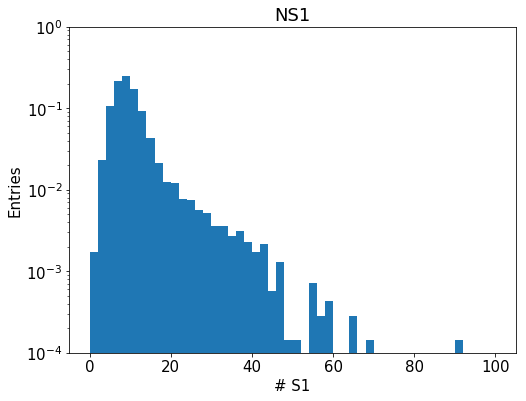

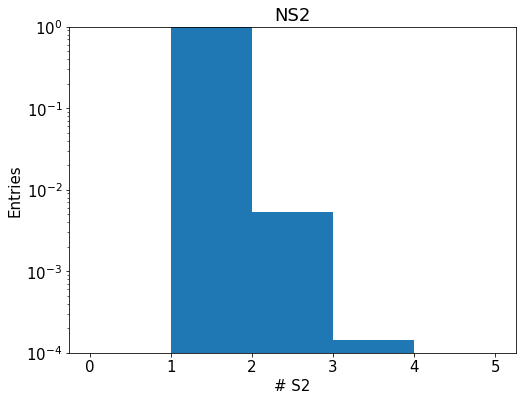

In [35]:
pdf(data.nS1, 50, range=(0, 100))
labels("# S1", "Entries")
save("NS1")

################################
pdf(data.nS2, 5, range=(0, 5))
labels("# S2", "Entries")
save("NS2")


<b>
1. The number of events under these conditions is not uniformly distributed in Z. Near the anode about ~25% of the events lack S1.
2. Integrating the lack of events in the whole chamber, we get a Kr detection efficiency of ~94.0%.
</b>

## Width of S1 signals

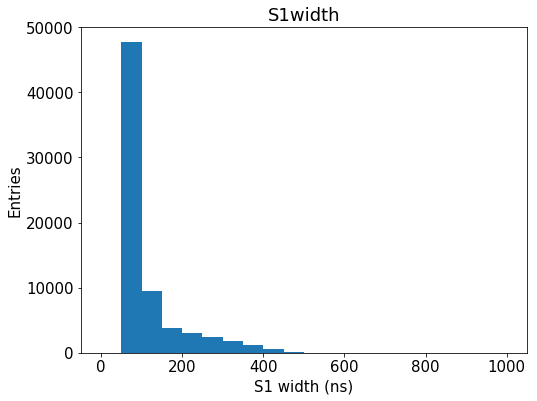

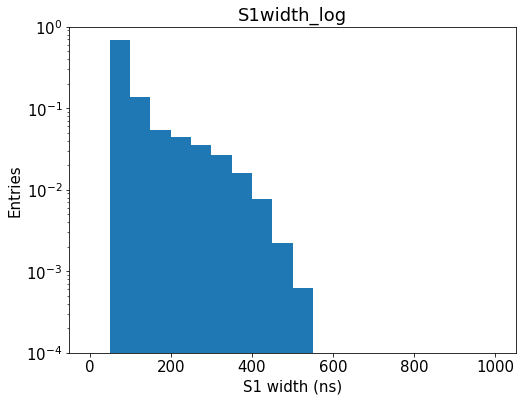

In [77]:
s1w = flat(data.S1w)

################################
hist(s1w, 20, range=(0, 1000))
labels("S1 width (ns)", "Entries")
save("S1width")

################################
pdf(s1w, 20, range=(0, 1000))
labels("S1 width (ns)", "Entries")
save("S1width_log")


# Height of S1 signals

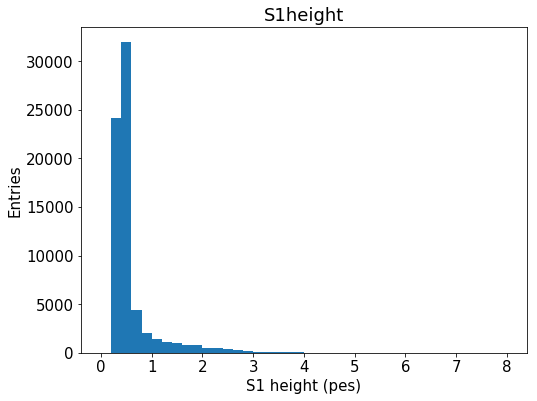

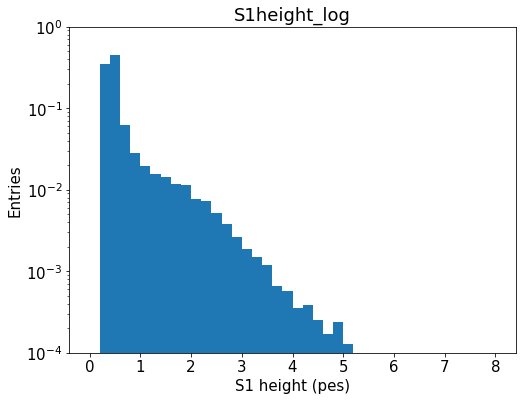

In [78]:
s1h = flat(data.S1h)

################################
hist(s1h, 40, range=(0, 8))
labels("S1 height (pes)", "Entries")
save("S1height")

################################
pdf(s1h, 40, range=(0, 8))
labels("S1 height (pes)", "Entries")
save("S1height_log")

## S1 energy

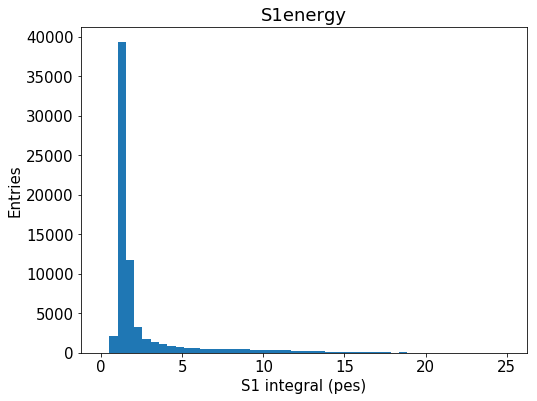

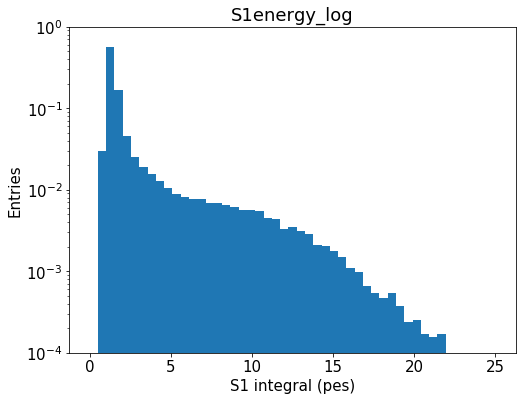

In [79]:
s1i = flat(data.S1i)

################################
hist(s1i, np.linspace(0, 25, 50, endpoint=True))
labels("S1 integral (pes)", "Entries")
save("S1energy")

################################
pdf(s1i, np.linspace(0, 25, 50, endpoint=True))
labels("S1 integral (pes)", "Entries")
save("S1energy_log")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


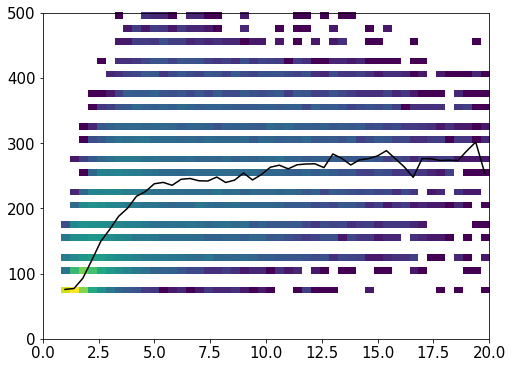

In [95]:
from matplotlib.colors import LogNorm
hist2d(s1i, s1w, (50, 50), range=((0, 20), (0, 500)), norm=LogNorm());


x, y, ye = fitf.profileX(s1i, s1w, 50, (0, 20))
plt.plot(x, y, "k")

## S1 peak-to-area ratio

/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:119: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


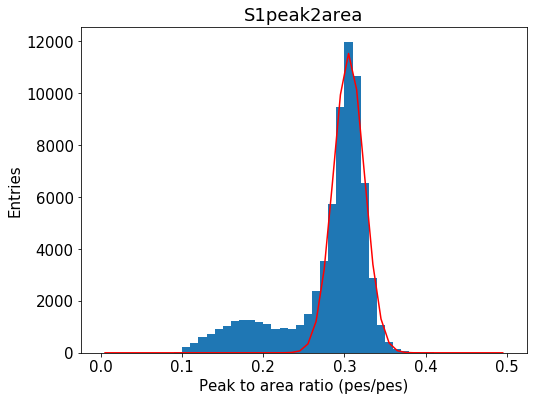

In [81]:
ratio = s1h/s1i
################################
y, x, _ = hist(ratio, 50, range=(0, 0.5))
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 0.3, 0.01))
plt.plot(x, f.fn(x), "r")
labels("Peak to area ratio (pes/pes)", "Entries")
save("S1peak2area")

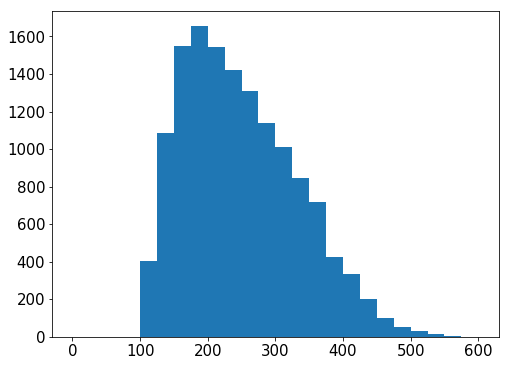

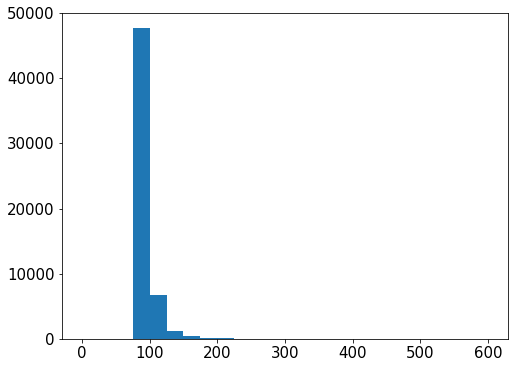

In [85]:
s1w_small_ratio = s1w[ratio<0.25]
s1w_large_ratio = s1w[ratio>0.25]

hist(s1w_small_ratio, 24, (0, 600))
hist(s1w_large_ratio, 24, (0, 600));


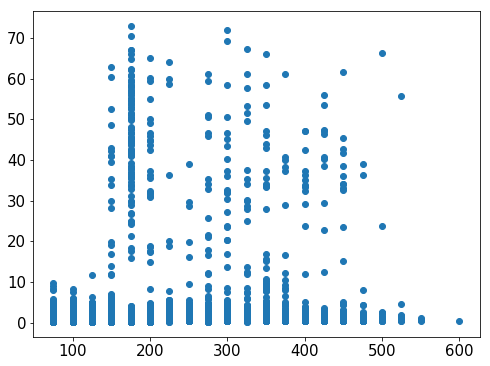

In [76]:
s1h = flat(data.S1h)
s1w = flat(data.S1w)
scatter(s1w, s1h)

#plt.figure()
#plt.hist2d(s1w, s1h, 50, range=((50, 550), (0, 80)))
#plt.ylim(0,8)

/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:119: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


(array([  2.38300000e+03,   3.52800000e+03,   5.20000000e+02,
          1.91000000e+02,   9.50000000e+01,   7.90000000e+01,
          6.40000000e+01,   4.70000000e+01,   3.60000000e+01,
          1.30000000e+01,   2.00000000e+01,   6.00000000e+00,
          1.10000000e+01,   6.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   0.00000000e+00]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]),
 <a list of 20 Patch objects>)

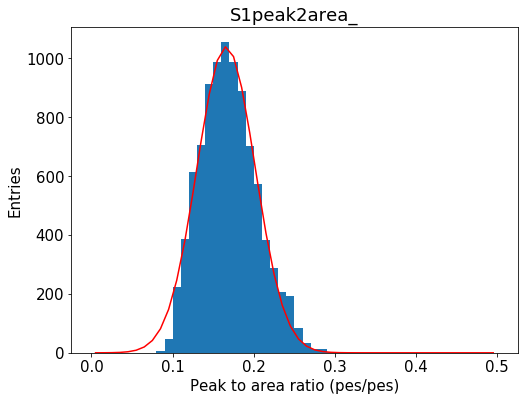

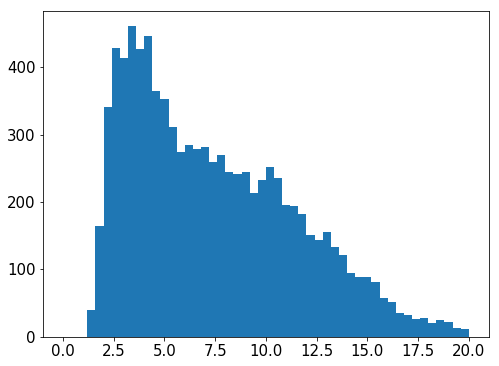

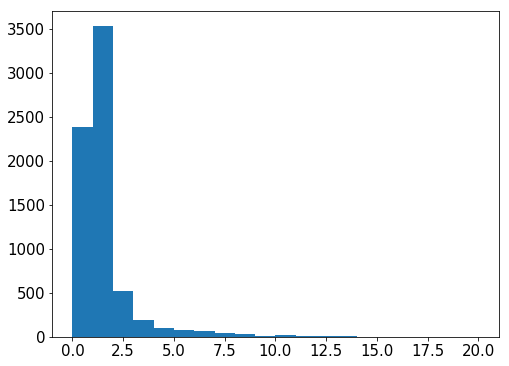

In [64]:
s1w = flat(data.S1w)
selection = s1w >= 200
s1h = flat(data.S1h)[selection]
s1i = flat(data.S1i)[selection]
nS1 = [np.count_nonzero(np.array(evt.S1w)>200) for evt in data.evts]

################################
y, x, _ = hist(s1h/s1i, 50, range=(0, 0.5))
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 0.3, 0.01))
plt.plot(x, f.fn(x), "r")
labels("Peak to area ratio (pes/pes)", "Entries")
save("S1peak2area_")

hist(s1i, 50, range=(0, 20))

hist(nS1, 20, range=(0, 20))

<b>
1. The peak to area ratio *was* roughtly gaussianly distributed. Allowing shorter S1s has introduced a slight tail towards high values, but the range is roughtly the same. On average, the ratio is ~26%.
</b>

## Width of S2 signals

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


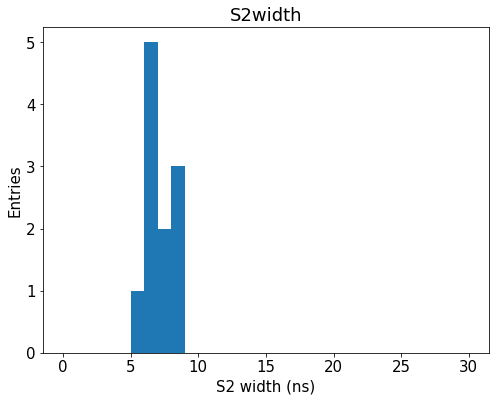

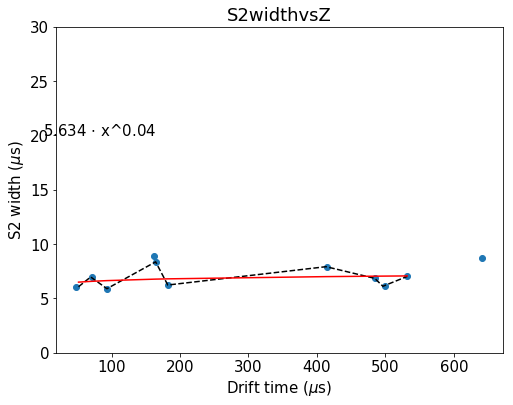

In [18]:
s2w = flat(data.S2w)

################################
hist(s2w, 30, range=(0, 30))
labels("S2 width (ns)", "Entries")
save("S2width")

################################
scatter(data.Z, s2w)
x, y, _ = fitf.profileX(data.Z, s2w, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.power, x, y, (1., 0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 20, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
labels("Drift time ($\mu$s)", "S2 width ($\mu$s)")
plt.ylim(0, 30)
save("S2widthvsZ")

<b>
1. The width of a Kr event is ~8 mm, but it depends on z as x^0.4 (although diffussion is ~√ )
</b>

# Height of S2 signals

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


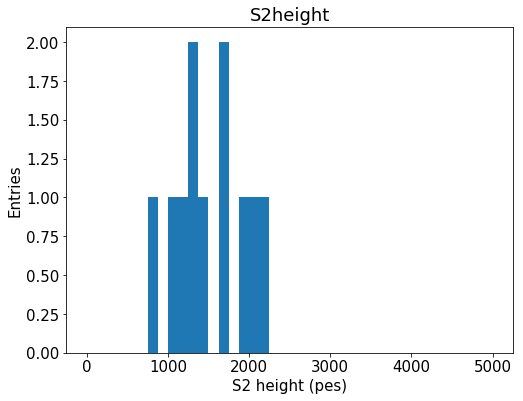

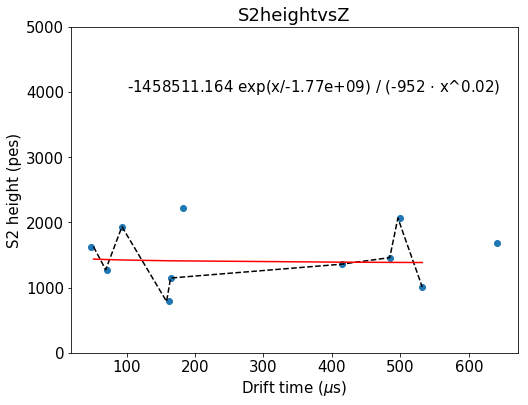

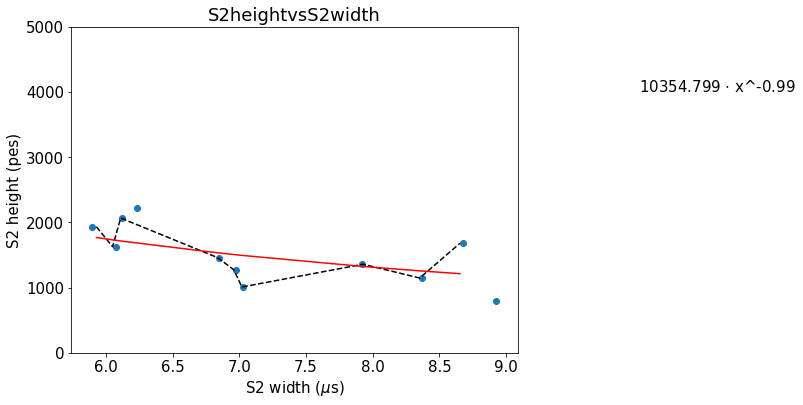

In [19]:
s2h = flat(data.S2h)

################################
hist(s2h, 40, range=(0, 5e3))
labels("S2 height (pes)", "Entries")
save("S2height")

################################
scatter(data.Z, s2h)
x, y, _ = fitf.profileX(data.Z, s2h, 100)
plt.plot(x, y, profOpt)
fun = lambda x, *args: fitf.expo(x,*args[:2])/fitf.power(x, *args[2:])
f = fitf.fit(fun, x, y, (1., -2e4, 0.1, -0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(1e2, 4e3, "{:.3f} exp(x/{:.3g}) / "
                   "({:.3g} $\cdot$ x^{:.2f})".format(*f.values))
labels("Drift time ($\mu$s)", "S2 height (pes)")
plt.ylim(0, 5e3)
save("S2heightvsZ")

################################
scatter(s2w, s2h)
x, y, _ = fitf.profileX(s2w, s2h, 50)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.power, x, y, (1., -1.0))
plt.plot(x, f.fn(x), fitOpt)
plt.text(10, 4e3, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
labels("S2 width ($\mu$s)", "S2 height (pes)")
plt.ylim(0, 5e3)
save("S2heightvsS2width")


<b>
1. The height of an S2 is distributed in a funny manner, but this is just a reflection of its distribution against Z. I don’t really understand the oscillations of the profile for Z < 200 $\mu$s. It is also correlated, as expected, with the width, however, the dependence does not match exactly what I expected (gaussian => h ~ 1/w).
</b>

## S2 energy

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3

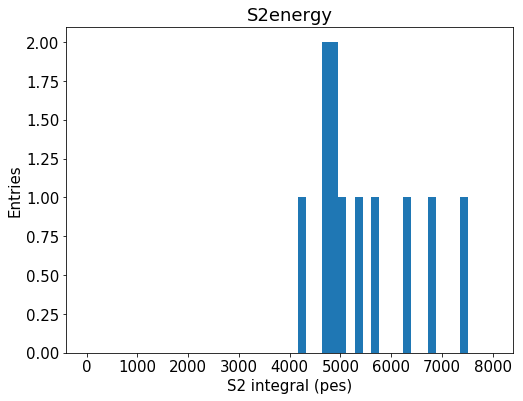

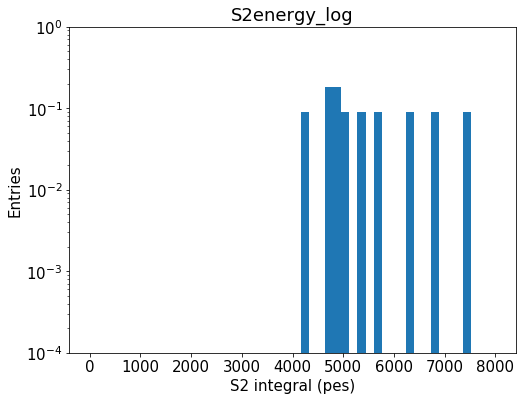

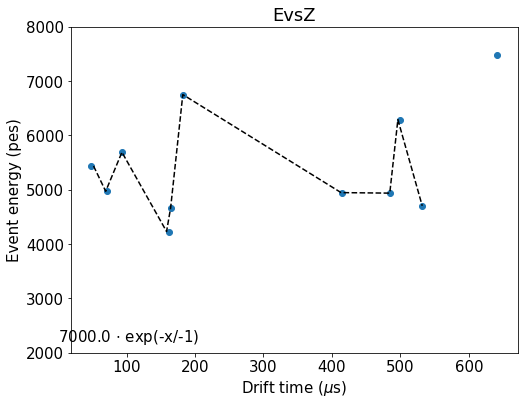

In [20]:
s2i = flat(data.S2i)

################################
hist(s2i, 50, range=(0, 8e3))
labels("S2 integral (pes)", "Entries")
save("S2energy")

################################
pdf(s2i, 50, range=(0, 8e3))
labels("S2 integral (pes)", "Entries")
save("S2energy_log")

################################
scatter(data.Z, s2i)
x, y, _ = fitf.profileX(data.Z, s2i, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.expo, x, y, (7e3, -1))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 2200, "{:.1f} $\cdot$ exp(-x/{:.4g})".format(*f.values))
labels("Drift time ($\mu$s)", "Event energy (pes)")
plt.ylim(2e3, 8e3)
save("EvsZ")

def get_zcorr(f):
    f = copy.copy(f)
    zmax = f(0)
    def zcorr(z):
        return zmax/f(z)
    return zcorr
zcorr = get_zcorr(f.fn)

<b>
1. The integrated Kr S2 signal peaks around 6500 pes, but it depends strongly on the geometrical position of the event (more on that later). When unfolding the distribution in Z, we find that there is a (non-negligible) dependence. The difference is a 2% which for this scale, represents ~110 pes. Since the MC was generated without any type of attachment, this dependence must be introduced somewhere in the IC code (Diomira?, Irene (when performing the deconvolution)?).
</b>

## S2 peak-to-area ratio

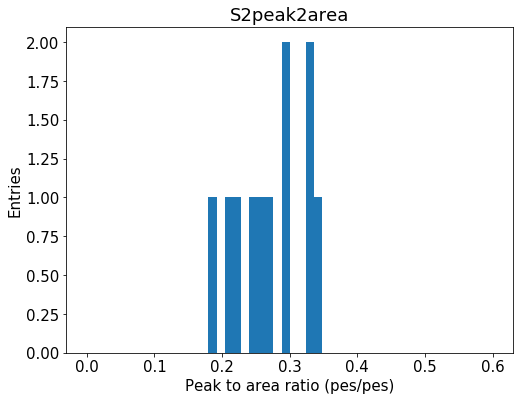

In [21]:
################################
hist(s2h/s2i, 50, range=(0, 0.6))
labels("Peak to area ratio (pes/pes)", "Entries")
save("S2peak2area")

<b>
1. The peak to area ratio seems to be composed of different types of peaks (~0.2, ~0.32, ~0.42, ~0.5). Not yet understood, but surely related to the structure found in the height of S2 signals. The shorter S2s now allowed have increased the significance of these peaks.
</b>

## S2 vs S1

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


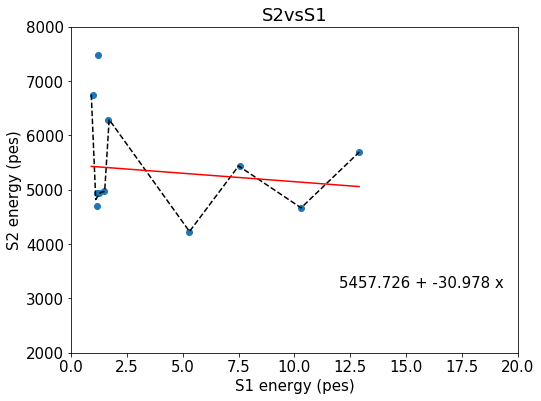

In [22]:
################################
scatter(s1i, s2i)
x, y, _ = fitf.profileX(s1i, s2i, 100, (0, 20))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (6e3, -1.))
plt.plot(x, f.fn(x), fitOpt)
plt.text(12, 3200, "{:.3f} + {:.3f} x".format(*f.values))
labels("S1 energy (pes)", "S2 energy (pes)")
plt.xlim(0, 20)
plt.ylim(2e3, 8e3)
save("S2vsS1")


<b>
1. S2 energy is also (anti)correlated with S1 charge. I don’t know where does this come from as there is no recombination in the MC. It may be caused purely by the S2 vs Z dependence.
2. The softer S1 and S2 selections have made this dependence stronger (the slope almost doubled).
</b>

## Number of SiPMs touched

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3

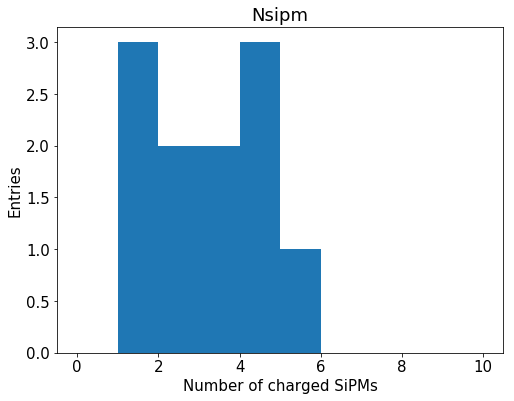

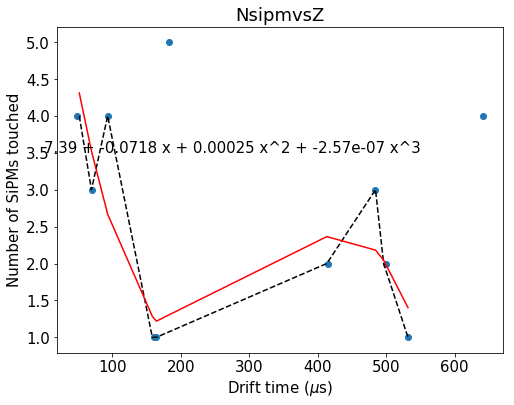

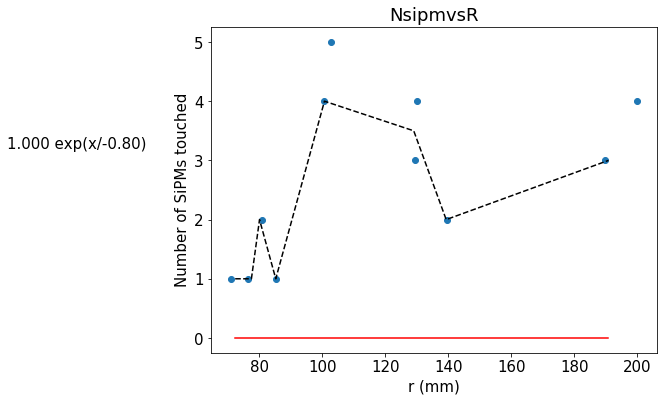

In [23]:
nsipm = flat(data.Nsipm)

################################
hist(nsipm, 10, range=(0, 10))
labels("Number of charged SiPMs", "Entries")
save("Nsipm")

################################
scatter(data.Z, nsipm)
x, y, _ = fitf.profileX(data.Z, nsipm, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (2, -1e-5, -1e-2, -1e-3))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 3.5, "{:.3g} + {:.3g} x + {:.3g} x^2 + {:.3g} x^3".format(*f.values))
labels("Drift time ($\mu$s)", "Number of SiPMs touched")
save("NsipmvsZ")

################################
selection = ~np.isnan(data.R)
R = data.R[selection]
scatter(R, nsipm[selection])
x, y, _ = fitf.profileX(R, nsipm[selection], 50)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.expo, x, y, (1., -0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 3.2, "{:.3f} exp(x/{:.2f})".format(*f.values))
labels("r (mm)", "Number of SiPMs touched")
save("NsipmvsR")


<b>
1. The number of SiPMs with signal over threshold has increased drastically. Now we have at least 4 SiPMs (which is enough for computing the barycenter) most of the time.
2. Unfolding the distribution in z tells us that the farther from the anode, the more SiPMs are touched, on average. This has the opposite behaviour than the previous (biased) production. Now, it seems that, as expected, transverse diffusion makes it easier to reach more sensors.
3. The number of SiPMs does not depend significantly on the transverse position of the event, as shown.
4. The last plot is made with Nsipm>0 (as R would not make sense).
</b>

## To study geometrical dependendes, we will select those events with Nsipm > 0

In [24]:
atleast1sipm = oneS1oneS2[flat(oneS1oneS2.Nsipm) > 0]
data         = atleast1sipm

Time spent in _create_attrs: 0.000308990478515625 s


## Event distribution in the X, Y plane

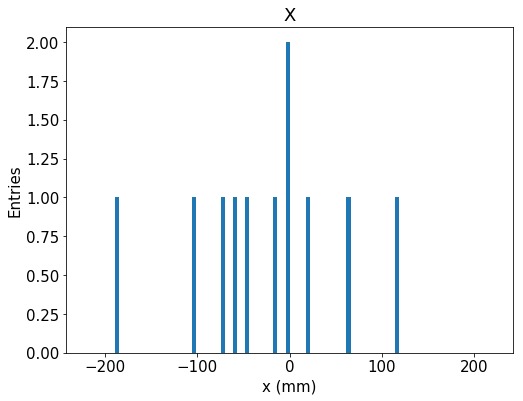

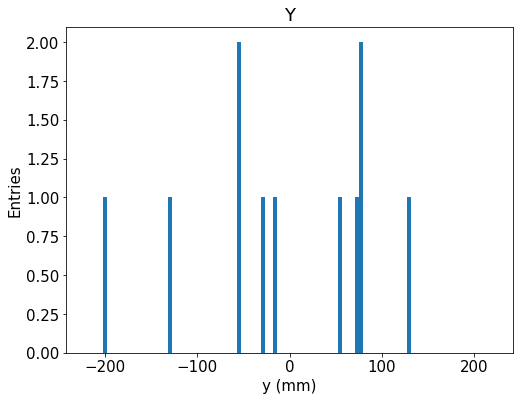

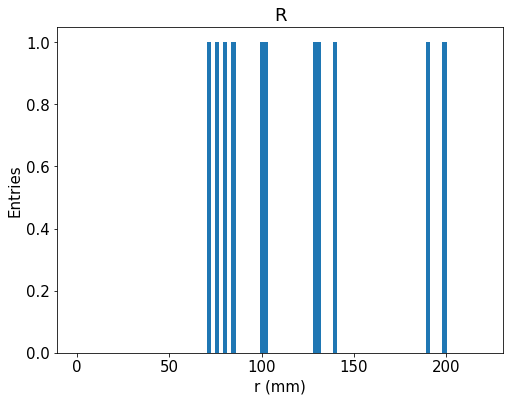

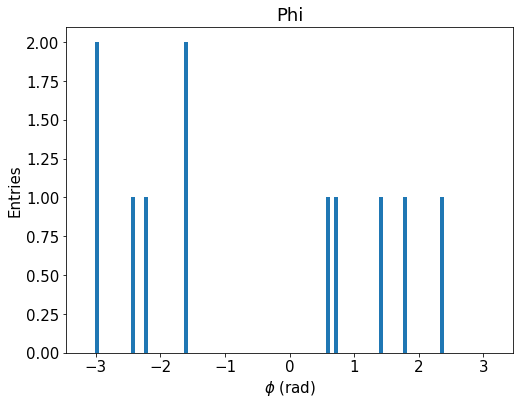

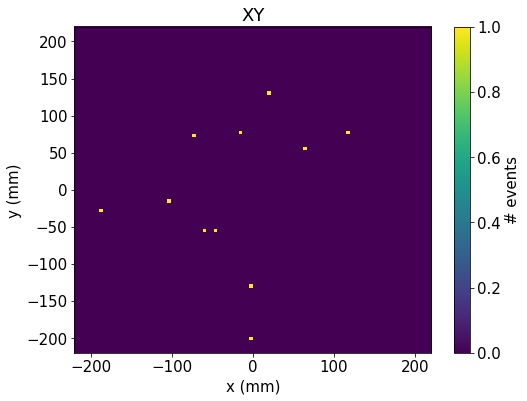

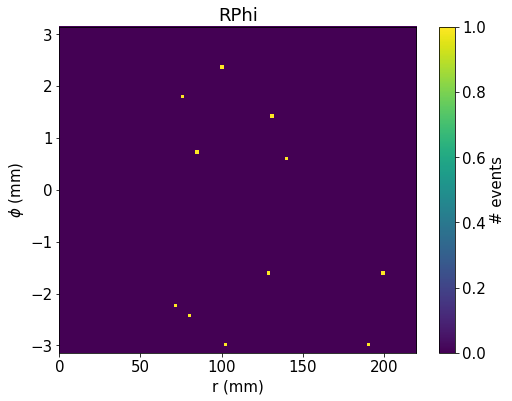

In [25]:
X, Y, R, Phi = flat(data.X), flat(data.Y), flat(data.R), flat(data.Phi)

################################
hist(X, 100, range=(-220, 220))
labels("x (mm)", "Entries")
save("X")

################################
hist(Y, 100, range=(-220, 220))
labels("y (mm)", "Entries")
save("Y")

################################
hist(R, 100, range=(0, 220))
labels("r (mm)", "Entries")
save("R")

################################
hist(Phi, 100, range=(-pi, pi))
labels("$\phi$ (rad)", "Entries")
save("Phi")

################################
hist2d(X, Y, 100, range=((-220, 220),
                         (-220, 220)))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)")
save("XY")

################################
hist2d(R, Phi, 100, range=((  0, 220),
                           (-pi, pi )))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)")
save("RPhi")


<b>
1. The distribution of events (computed using the barycenter) is, as expected. There is still some "bias" towards the SiPMs positions, but much less than before.
2. Because there is a dead SiPM at (5, -155) there is a hole in the number of events there.
</b>

## S2 charge

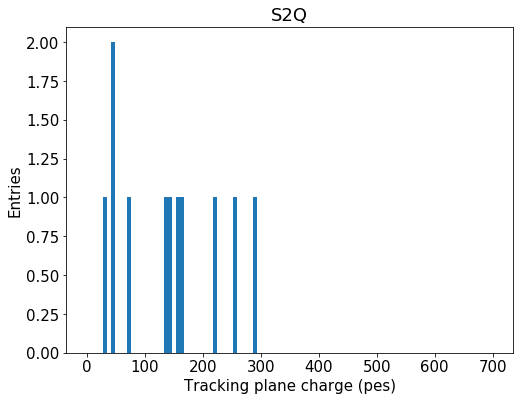

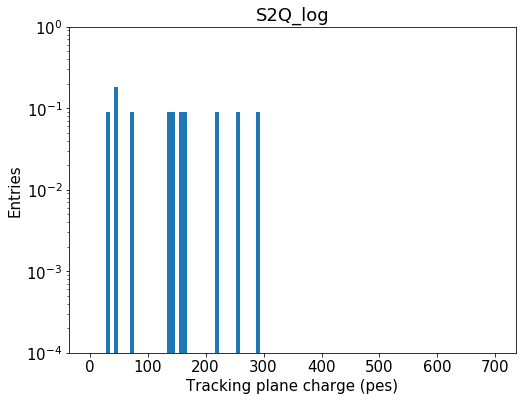

In [26]:
################################
s2q = flat(data.Q)
hist(s2q, 100, range=(0, 700))
labels("Tracking plane charge (pes)", "Entries")
save("S2Q")

################################
pdf(s2q, 100, range=(0, 700))
labels("Tracking plane charge (pes)", "Entries")
save("S2Q_log")

<b>
1. The total charge (integral of the tracking plane) is weirdly distributed, but close to a gaussian form. We need to look at its dependences.
</b>

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Gonzalo/github/I

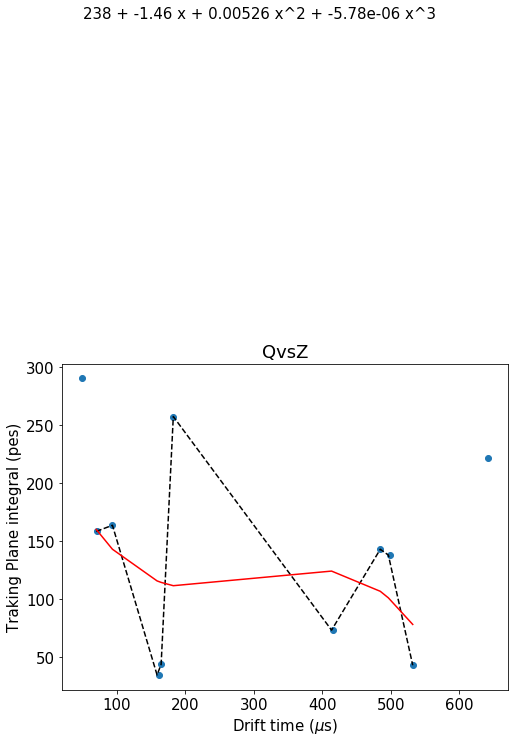

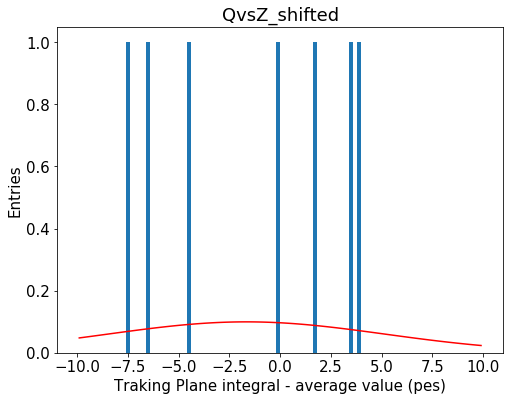

In [27]:
################################
scatter(data.Z, s2q)
x, y, _ = fitf.profileX(data.Z, s2q, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (400, -1, 0.1, 0.01))
plt.plot(x, f.fn(x), fitOpt)
plt.text(50, 600, "{:.3g} + {:.3g} x + {:.3g} x^2 + {:.3g} x^3".format(*f.values))
labels("Drift time ($\mu$s)", "Traking Plane integral (pes)")
save("QvsZ")

################################
sel = fitf.in_range(data.Z, 50, 500)
ave = f.fn(data.Z[sel])
y, x, _ = hist((s2q[sel] - ave)/ave**0.5, 100, range=(-10, 10))
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e4, 0, 5))
plt.plot(x, f.fn(x), "r")
labels("Traking Plane integral - average value (pes)", "Entries")
save("QvsZ_shifted")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


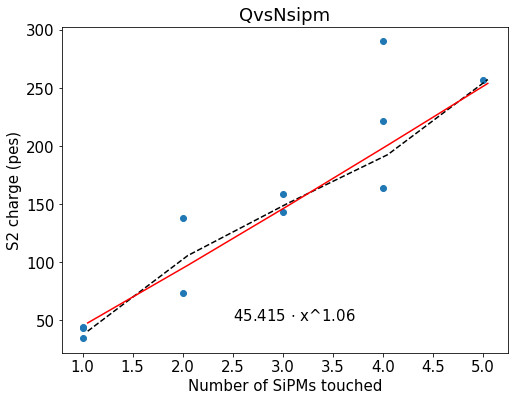

In [28]:
nsipm = flat(data.Nsipm)
################################
scatter(nsipm, s2q)
x, y, _ = fitf.profileX(nsipm, s2q, 100, xrange=(0, 10))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.power, x, y, (100, 0.7))
plt.plot(x, f.fn(x), fitOpt)
plt.text(2.5, 50, "{:.3f} $\cdot$ x^{:.2f}".format(*f.values))
labels("Number of SiPMs touched", "S2 charge (pes)")
save("QvsNsipm")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


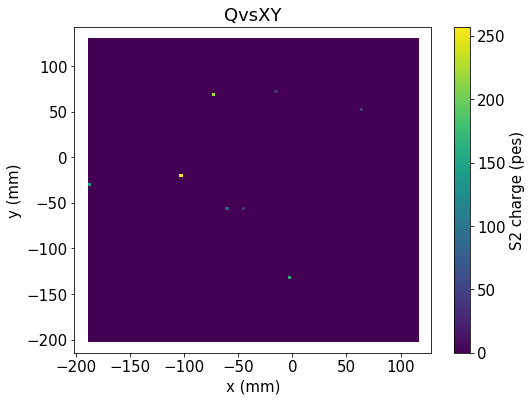

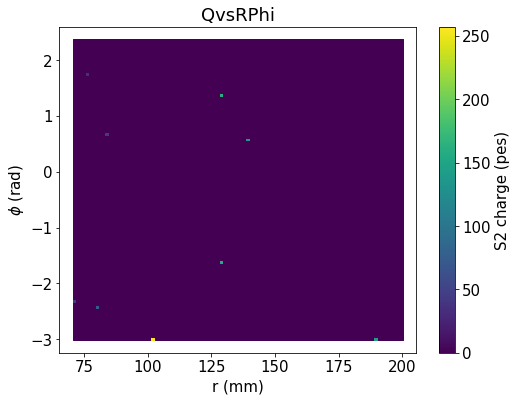

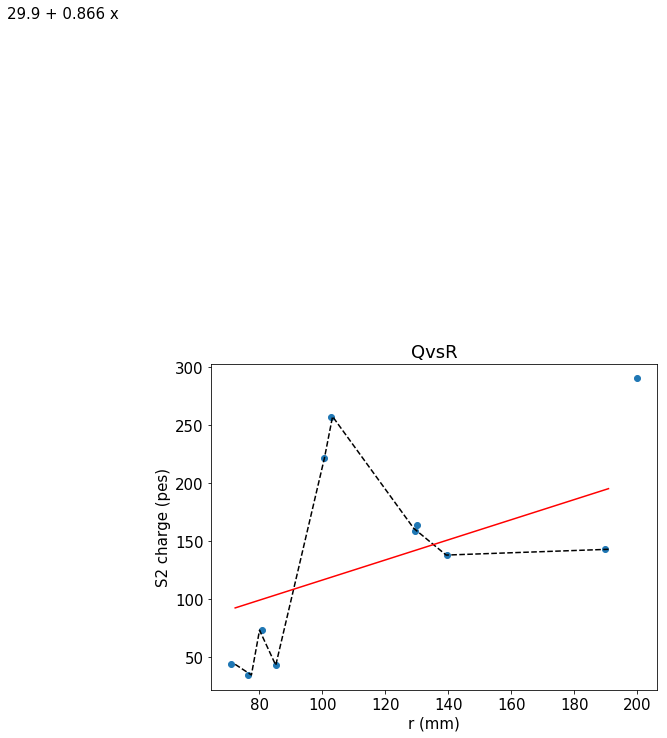

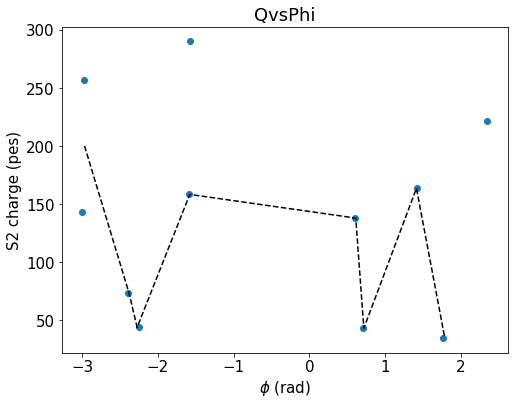

In [29]:
################################
plt.figure()
x, y, q, qe = fitf.profileXY(X, Y, s2q, 100, 100)
x = np.repeat(x, x.size)
y = np.tile(y, y.size)
q = np.concatenate(q)
plt.scatter(x, y, c=q, marker="s")
plt.colorbar().set_label("S2 charge (pes)")
labels("x (mm)", "y (mm)")
save("QvsXY")

################################
plt.figure()
x, y, q, qe = fitf.profileXY(R, Phi, s2q, 100, 100)
x = np.repeat(x, x.size)
y = np.tile(y, y.size)
q = np.concatenate(q)
plt.scatter(x, y, c=q, marker="s")
plt.colorbar().set_label("S2 charge (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("QvsRPhi")

################################
scatter(R, s2q)
x, y, _ = fitf.profileX(R, s2q, 50)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (200, -0.001))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 600, "{:.3g} + {:.3g} x".format(*f.values))
labels("r (mm)", "S2 charge (pes)")
save("QvsR")

################################
scatter(Phi, s2q)
x, y, _ = fitf.profileX(Phi, s2q, 100)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "S2 charge (pes)")
save("QvsPhi")

<b>
After taking a look to the dependencies of this magnitude we see that:
    - Charge collection is homogeneous in the TP.
    - It depends on the number of SiPMs touched ~linearly, but there is a strange bump at Nsipm = 2-3
    - There is a strong dependence on Z. While events occurring near the anode have ~400 pes, those at the cathode have ~20% less. On the other hand, if we take Q - averageQ for 50 < Z < 500 mus, the distribution seems gaussianly distributed, as expected. Therefore, we can conclude that charge variation in Z is the dominant effect in the TP.
</b>

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/nu

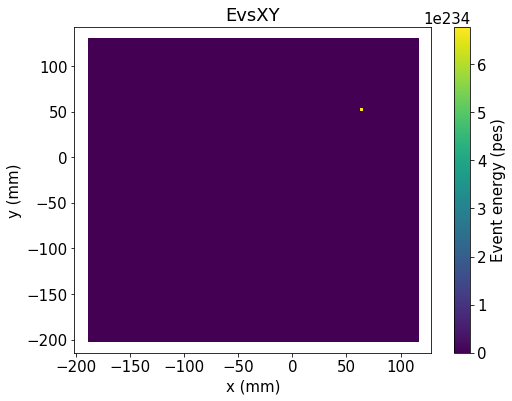

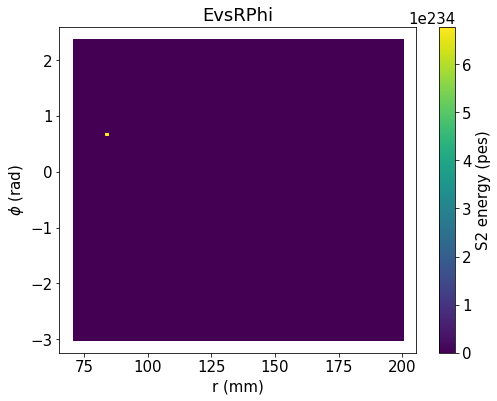

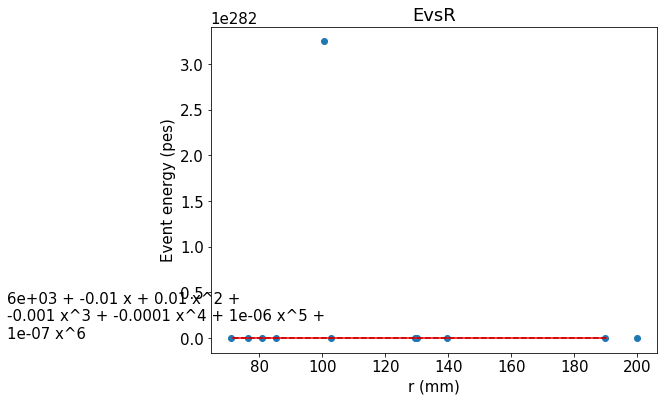

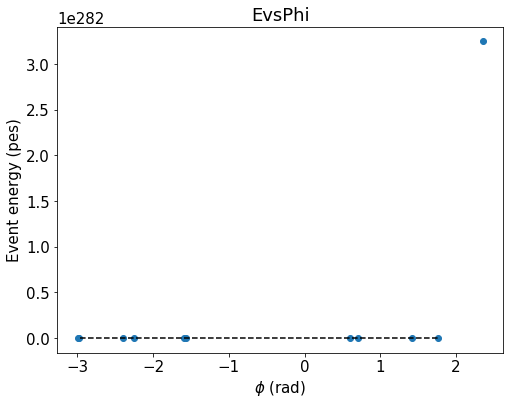

In [30]:
s2e = flat(data.S2i) * zcorr(flat(data.Z))

################################
plt.figure()
x_, y_, q_, qe_ = fitf.profileXY(X, Y, s2e, 100, 100)
x = np.repeat(x_, x_.size)
y = np.tile(y_, y_.size)
q = np.concatenate(q_)
plt.scatter(x, y, c=q, marker="s")
plt.colorbar().set_label("Event energy (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

def get_xycorr(xs, ys, qs, qe):
    valid = np.ma.masked_invalid(qe/qs)
    qmax  = np.max(qs)
    xs = xs.reshape(xs.size, 1)
    ys = ys.reshape(ys.size, 1)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        return qmax/qs[x_closest, y_closest]
    return xycorr
xycorr = get_xycorr(x_, y_, q_, qe_)

################################
plt.figure()
x, y, q, qe = fitf.profileXY(R, Phi, s2e, 100, 100)
x = np.repeat(x, x.size)
y = np.tile(y, y.size)
q = np.concatenate(q)
plt.scatter(x, y, c=q, marker="s")
plt.colorbar().set_label("S2 energy (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

################################
scatter(R, s2e)
x, y, _ = fitf.profileX(R, s2e, 100)
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (6e3, -1e-2, 1e-2, -1e-3, -1e-4, 1e-6, 1e-7))
plt.plot(x, f.fn(x), fitOpt)
plt.text(0, 3e3, "{:.3g} + {:.3g} x + {:.3g} x^2 + \n"
                 "{:.3g} x^3 + {:.3g} x^4 + {:.3g} x^5 +\n"
                 "{:.3g} x^6".format(*f.values))
labels("r (mm)", "Event energy (pes)")
save("EvsR")

################################
scatter(Phi, s2e)
x, y, _ = fitf.profileX(Phi, s2e, 100)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "Event energy (pes)")
save("EvsPhi")

<b>
1. Finally, the dependence of the energy with the position is obvious. The behaviour in R and $\phi$ are the ones expected from the parametrization. The Kr energy map seems quite good. The improvement in the number of SiPMs touched has made the map much smoother.
</b>

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: Improper input: N=3 must not exceed M=0

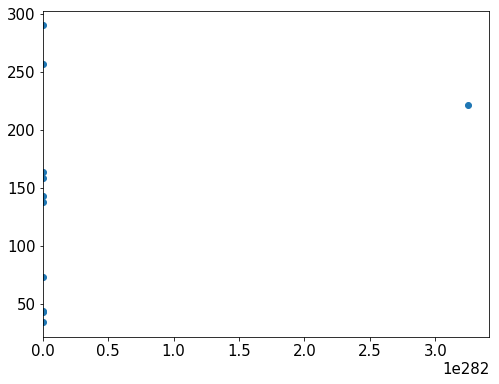

In [31]:
################################
scatter(s2e, s2q)
plt.xlim(3500)
x, y, _ = fitf.profileX(s2e, s2q, 100, (4700, 7200))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (200, 1e-2, 1e-4))
plt.plot(x, f.fn(x), fitOpt)
plt.text(3600, 700, "{:.3g} + {:.3g} x + {:.3g} x^2".format(*f.values))
labels("S2 energy (pes)", "S2 charge (pes)")
save("QvsE")

<b>
1. The meaning of the charge vs energy plot is not clear. The only dependences are Q(Z) and E(R) (E(z) is negligible compared with the other one), so the quadratic correlation does not seem obvious to me.
</b>

In [ ]:
################################
qsipm = flat(data.Qsipm)
hist(qsipm, 100, range=(0, 600))
labels("SiPM charge (pes)", "Entries")
save("SipmQ")

################################
pdf(qsipm, 100, range=(0, 600))
labels("SiPM charge (pes)", "Entries")
save("SipmQ_log")

<b>
1. The charge per SiPM shows that the majority of them have less than 100 pes, but, in the best-case scenario, they can reach up to 400 pes. However, since this charge is time-integrated, the lower bound of the distribution is shifted towards the ~5 pes/$\mu$s region, very close to the ZS cut.
</b>

In [ ]:
################################
order, charge, norm_charge = [], [], []
for evt in data.Qsipm:
    for peak in evt:
        maxq = np.sum(peak)
        for i, q in enumerate(sorted(peak, reverse=True)):
            order.append(i)
            charge.append(q)
            norm_charge.append(q/maxq)

order, charge, norm_charge = map(np.array, [order, charge, norm_charge])
scatter(order, charge)
x, y, _ = fitf.profileX(order, charge, 100, (0, max(order)+1))
plt.plot(x, y, profOpt)
labels("Ordering", "SiPM charge (pes)")
save("SipmQordered")

###########################
scatter(order, norm_charge)
x, y, _ = fitf.profileX(order, norm_charge, 100, (0, max(order)+1))
plt.plot(x, y, profOpt)
labels("Ordering", "SiPM normalized charge (pes/pes)")
save("SipmQnormordered")

## Spread of the events

In [ ]:
################################
hist(flat(data.Xrms), 100, range=(0, 10))
labels("rms x (mm)", "Entries")
save("rmsX_full")

################################
hist(flat(data.Yrms), 100, range=(0, 10))
labels("rms y (mm)", "Entries")
save("rmsY_full")

<b>
1. The spread of the event can be measured by the standard deviation of X and Y. In this plot we see a major contribution of those event with Nsipm < 4 at ~5 mm. There is still a tiny fraction of the events that have 1 SiPM or less. We must remove them to continue.
</b>

In [ ]:
rmsnotzero = data[(data.Xrms > 1e-3) & (data.Yrms > 1e-3)]
data = rmsnotzero

In [ ]:
xrms, yrms = data.Xrms, data.Yrms

################################
hist(xrms, 100, range=(0, 10))
labels("rms x (mm)", "Entries")
save("rmsX")

################################
hist(yrms, 100, range=(0, 10))
labels("rms y (mm)", "Entries")
save("rmsY")

################################
scatter(data.Z, xrms)
x, y, _ = fitf.profileX(data.Z, xrms, 100, yrange=(0,30))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (1., 0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(100, 130, "{:.3f} + {:.3f} x".format(*f.values))
labels("Drift time ($\mu$s)", "rms x (mm)")
save("rmsXvsZ")

################################
scatter(data.Z, yrms)
x, y, _ = fitf.profileX(data.Z, yrms, 100, yrange=(0,30))
plt.plot(x, y, profOpt)
f = fitf.fit(fitf.polynom, x, y, (1., 0.8))
plt.plot(x, f.fn(x), fitOpt)
plt.text(100, 130, "{:.3f} + {:.3f} x".format(*f.values))
labels("Drift time ($\mu$s)", "rms y (mm)")
save("rmsYvsZ")

<b>
1. The same distributions after the second selection are more clear. These are unfolded in Z and it seems that the spread of the event increases slightly with Z.
</b>

In [ ]:
def reso(values):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (41.5/2458)**0.5
E = flat(atleast1sipm.S2i)
Z = flat(atleast1sipm.Z)
X = flat(atleast1sipm.X)
Y = flat(atleast1sipm.Y)

Ecorr = E * zcorr(Z)
Ecorr = E * xycorr(X, Y)

y, x, _ = hist(Ecorr, 200, range=(5.5e3, 9e3))
x = x[:-1] + np.diff(x) * 0.5
f = fitf.fit(fitf.gauss, x, y, (1e5, 7e3, 5e2))
plt.plot(x, f.fn(x), fitOpt)
plt.text(5500, 5e3, ("$\mu$ = {:.1f}\n"
                     "$\sigma$ = {:.2f}\n"
                     "R = {:.3}%\n"
                     "Rbb = {:.3}%").format(*f.values[1:], *reso(f.values)))
labels("Corrected energy (pes)", "Entries")
save("Ecorr")

hist(Ecorr, 200, range=(5.5e3, 9e3))
plt.plot(x, f.fn(x), fitOpt)
plt.yscale("log")
plt.ylim(1, 1e4)
plt.text(5500, 1e3, ("$\mu$ = {:.1f}\n"
                     "$\sigma$ = {:.2f}\n"
                     "R = {:.3}%\n"
                     "Rbb = {:.3}%").format(*f.values[1:], *reso(f.values)))
labels("Corrected energy (pes)", "Entries")
save("Ecorr_log")